# 1 - Inicialización y carga de datos

## 1.1. Importanción de librerias

In [ ]:
import os, types
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from botocore.client import Config
import ibm_boto3

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

%matplotlib inline

## 1.2.  Variables

In [4]:
RANDOM_STATE = 288

## 1.3. Carga de datos

In [5]:
# Carga de datos
df = pd.read_csv(body)
df.set_index('empleado_id', inplace=True)

In [6]:
# División de los datos en train y set
X, y = df.drop('target', axis=1), df['target']

# 2. Análisis inicial de los datos

In [10]:
X['nivel_educacion'].value_counts()

Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: nivel_educacion, dtype: int64

In [8]:
pd.Series(LabelEncoder().fit_transform(SimpleImputer(strategy='constant', fill_value='missing').fit_transform(X[['nivel_educacion']]))).value_counts()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0    11598
2     4361
1     2017
5      460
3      414
4      308
dtype: int64

In [11]:
numeric_tf = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, ['horas_formacion', 'indice_desarrollo_ciudad']),
        ('cat', categorical_tf, ['ultimo_nuevo_trabajo', 'tamano_compania', 'experiencia', 'educacion', 'universidad_matriculado', 'nivel_educacion', 'experiencia_relevante']),
    ])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15326, 12), (15326,), (3832, 12), (3832,))

In [14]:
pd.DataFrame(preprocessor.fit_transform(X_train).toarray())

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.979049,0.788705,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.144332,-2.192565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.778717,0.740098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.139472,0.659085,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.890717,0.659085,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15321,0.778717,0.740098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15322,-0.339804,0.553768,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15323,1.145993,0.740098,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
15324,-0.172860,-0.823449,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
class Sparse2Array(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
    

class Clf(BaseEstimator):
    """Base model used to host classifiers on GridSearchCV"""
    def __init__(self, estimator=DummyClassifier()):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [11]:
pca = PCA()
X_preprocessed = pd.DataFrame(preprocessor.fit_transform(X).toarray())
X_preprocessed.shape

(19158, 53)

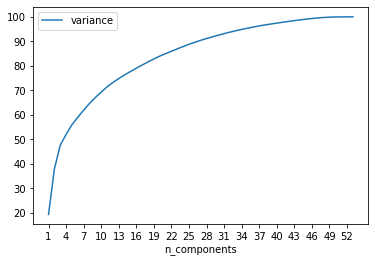

In [12]:
pca.fit(X_preprocessed)
pd.DataFrame({
    'n_components': range(1, len(X_preprocessed.columns) + 1),
    'variance': np.cumsum(pca.explained_variance_ratio_)*100         
    }).set_index('n_components').plot(xticks=range(1, 53, 3))

In [16]:
pipe = make_pipeline(preprocessor, Sparse2Array(), PCA(), Clf())

In [17]:
param_grid = [{
        'clf__estimator': [DummyClassifier()] # Este modelo nos sirve para comparar los resultados del resto respecto a la aleatoriedad
    },{
        'clf__estimator': [LogisticRegression()],
        'clf__estimator__solver': ['sag', 'saga'],
        'clf__estimator__max_iter': [100, 800], #default 100
        'clf__estimator__penalty': ['l2', 'none'], #default l2
        'pca__n_components': [30, 40, 52] # 52 = n_features before preprocessing
     },{
        'clf__estimator': [RandomForestClassifier()],
        'clf__estimator__criterion': ['entropy', 'gini'], #default gini
        'clf__estimator__n_estimators': [100, 150], #default 100
        'pca__n_components': [30, 40, 52]
    },{
        'clf__estimator': [SVC()],
        'clf__estimator__C': [1., 10.], # default 1.
        'clf__estimator__gamma': ['scale', 'auto'], # default scale
        'pca__n_components': [30, 40, 52]
    }]

In [18]:
gs = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=4, scoring='accuracy', return_train_score=True)

In [19]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:  3.4min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['horas_formacion',
                                                                          'indice_desarrollo_ciudad']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant'))

In [20]:
results = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score').reset_index()

In [24]:
results[['param_clf__estimator', 'mean_test_score', 'mean_train_score', 'param_pca__n_components']]

,param_clf__estimator,mean_test_score,mean_train_score,param_pca__n_components
0,SVC(),0.776458,0.816293,52
1,SVC(),0.776002,0.813259,40
2,SVC(),0.775088,0.810257,30
3,SVC(),0.773066,0.787583,40
4,SVC(),0.772413,0.790715,30
5,SVC(),0.772152,0.783766,52
6,SVC(),0.769738,0.776360,30
7,LogisticRegression(),0.769607,0.772021,52
8,LogisticRegression(),0.769607,0.772021,52
9,LogisticRegression(),0.769607,0.772021,52
